# Obligatorio - Taller Agentes Inteligentes 2023

Vamos a usar el juego Super Mario Bros:
PyPi: https://pypi.org/project/gym-super-mario-bros/ 
Repo: https://github.com/Kautenja/gym-super-mario-bros

En este caso, el juego está programado como un ambiente de OpenAI Gym, cumpliendo con las interfaces que hemos trabajado en el curso.


El objetivo del juego consta de lograr que nuestro personaje llegue al final de la pantalla, sin ser comido por enemigos o caer al vacío.

![](./assets/images/mario.gif)

Si bien el juego podría considerarse de múltiples agentes (mario, y sus enemigos), utilizaremos unicamente las heramientas del curso para solucionarlo, esto es, todo lo que no conforma a nuestros agentes será considerado ambiente y tratado como tal.

El objetivo es resolver el juego utilizando Deep Q Learning y Double Deep Q Learning, comparando sus resultados.


## Tareas:


1. Completar el código faltante en este notebook (y archivos asociados).


2. Entrenar un agente de Deep Q Learning (DQN) para cada ambiente tal que éste sea capaz de resolverlo.


3. Entrenar un agente de Double Deep Q Learning (DDQN) para cada ambiente tal que éste sea capaz de resolverlo.


4. Graficar las recompensas obtenidas para cada ambiente por cada agente (Ambos agentes resolviendo el ambiente 1 en una misma gráfica, idem para el ambiente 2). Escribir al menos 2 conclusiones de cada grafica. 


5. Grabar un video de cada agente resolviendo cada problema (pueden descargar el video desde colab y entregarlos dentro de un zip).


Recuerden que pueden usar la GPU en google colab para agilizar el entrenamiento. 
***


Fecha de entrega: **04/07** 21hs por gestión (gestion.ort.edu.uy). Pueden trabajar en grupos de hasta 3 estudiantes. 
***

Instalación de librerías. Se fija la versión de gym, dado que para dicha versión las ROMS de los juegos ya estan includias y se evita su instalación separada lo que puede originar problemas.

In [1]:
# Para el manejo de librerias se utilizo conda y estan especificadas en el archivo environment.yml
# Por instrucciones de como instalar conda ver: https://docs.conda.io/projects/conda/en/latest/user-guide/install/

Imports y configuraciones de ambiente

In [2]:
import os
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt

import math
import random
import numpy as np
from PIL import Image
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import mario_utils

Checkeo de devices

In [3]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Running on {DEVICE}")
print("Cuda Available:", torch.cuda.is_available())

Running on cuda:0
Cuda Available: True


Setting de seeds

In [4]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

Validacion del ambiente

In [5]:
ENV_NAME = "SuperMarioBros-1-1-v1"

env = mario_utils.make_env(ENV_NAME)
print("Actions #", env.action_space.n)
env.reset()
next_state, reward, done, info = env.step(action=0)
print(f"state shape: {next_state.shape},\n reward: {reward},\n done: {done},\n info: {info}")

Actions # 2
state shape: (4, 128, 128),
 reward: 0.0,
 done: False,
 info: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'y_pos': 79}


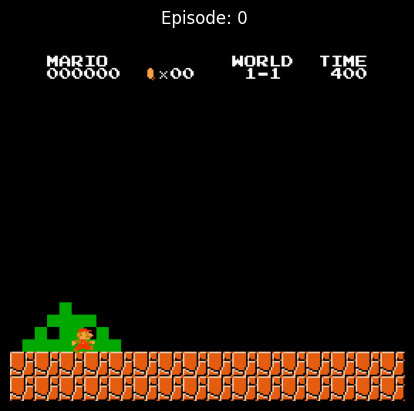

In [6]:
mario_utils.show_state(env)

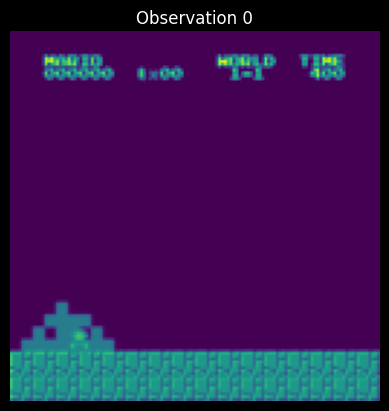

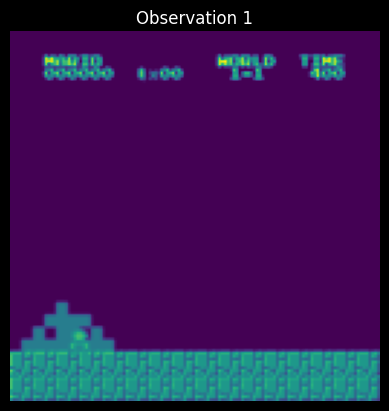

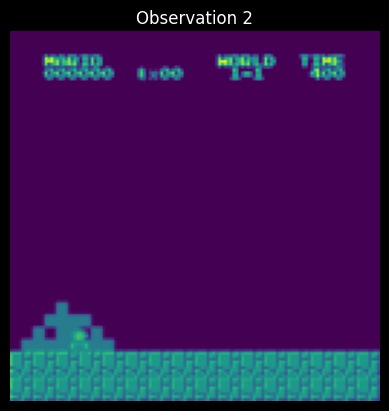

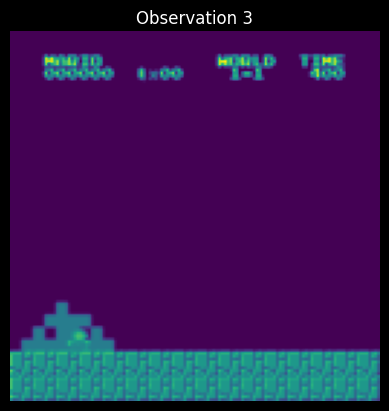

In [7]:
obs = env.reset()
obs, reward, done, info = env.step(0)
mario_utils.show_obs(obs)

In [8]:
from IPython.display import HTML
from pyvirtualdisplay import Display

display = Display(visible=0, size=(1400, 900), color_depth=16)
display.start()

wrapped_env = mario_utils.wrap_env(env)
state = wrapped_env.reset()

while True:
    wrapped_env.render()
    state, reward, done, info = wrapped_env.step(wrapped_env.action_space.sample())
    if done:
        break

wrapped_env.close()

In [9]:
mario_utils.show_video()

# Deep Q Learning


Recomendamos empezar implementando Deep Q Learning (paper presentado por DeepMind, pueden encontrar el mismo en arxiv: https://arxiv.org/pdf/1312.5602.pdf0).

***

En las celdas siguientes dejamos el código que deben implementar asi como una explicación del mismo.

# Memoria

El algoritmo de Deep Q Learning presentado en el paper utiliza una memoria (llamada Replay Memory) para almacenar transiciones pasadas. Tuplas que contienen un estado base, la accion tomada, la recompensa obtenida, una bandera que indica si el siguiente estado es final o no; y el estado siguiente.

Esta memoria es circular, es decir, tiene un límite maximo de elementos y una vez esté llena comienza a reemplazar los elementos más viejos.

Vamos a necesitar crear una función **sample** que obtiene una mustra aleatoria de elementos de la memoria.  Esto puede ser una lista de Transiciones o listas separadas (pero alineadas) de los elementos que las componen.

***

Para implementar esta funcionalidad se debe modificar el archivo **replay_memory.py**


In [10]:
from replay_memory import ReplayMemory

# Modelo

Vamos a usar un mismo modelo FeedForward para estos dos problemas (entrenado en cada problema particular). Recomendamos simplicidad en la creación del mismo, pero tienen total libertad al momento de implementarlo.

***
Para implementar esta funcionalidad se debe modificar el archivo **dqn_cnn_model.py**


In [11]:
from dqn_cnn_model import DQN_CNN_Model
from mario_utils import make_env

test_env = make_env(ENV_NAME)

test_net = DQN_CNN_Model(test_env.observation_space.shape, test_env.action_space.n).to(
    DEVICE
)

from torchsummary import summary

summary(test_net, test_env.observation_space.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 31, 31]           8,224
            Conv2d-2           [-1, 64, 14, 14]          32,832
            Conv2d-3           [-1, 64, 12, 12]          36,928
            Linear-4                  [-1, 512]       4,719,104
            Linear-5                    [-1, 2]           1,026
Total params: 4,798,114
Trainable params: 4,798,114
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/backward pass size (MB): 0.40
Params size (MB): 18.30
Estimated Total Size (MB): 18.96
----------------------------------------------------------------


# Agente

Vamos a definir una clase agente, encargado de interactuar con el ambiente y entrenar los modelos. Los métdos definidos deben funcionar para ambos problemas simplemente cambiando el modelo a utilizar para cada ambiente.

Abajo dejamos un esqueleto del mismo y las funciones a completar. Recomendamos no alterar la estructura del mismo, pero pueden definir las funciones auxiliares que consideren necesarias.

Una aclaracion particular es sobre los últimos tres parametros del agente, representan los valores de epsilon_inicial, epsilon_final y el tiempo (numero de steps) que tardamos en llegar del epsilon final al inicial (puede decrementarlo de forma lineal o exponencial en el número de steps).

***

Para implementar esta funcionalidad se debe modificar los archivos **abstract_agent.py**, **dqn_agent.py** y **double_dqn_agent.py**.

Funciones a completar:


1. init: que inicializa los parametros del agente.

2. compute_epsilon: que computa el valor actual de epsilon en base al número de pasos actuales.

3. select_action: Seleccionando acciones "epsilongreedy-mente" si estamos entranando y completamente greedy en otro caso.

4. train: que entrena el agente por un número dado de episodios de largo determinado.

5. record_test_episode: para grabar un episodio con el agente siempre seleccionando la mejor accion conocida.

# Entrenamiento

Para entrenar van a necesitar definir:

1. El ambiente.
2. Una instancia del modelo a utilizar para el problema (ej: `mario_model = DQNModel(espacio_obs, num_acciones)`.
3. La función para procesar los estados (phi en el paper) que es necesaria para poder usar el modelo de Pytorch con las representaciones de gym.

Una vez definido pueden llamar a la función train del agente para entrenarlo y problar las demás funciones.

***

Una de las cosas que recomendamos hacer para probar los algoritmos es entrenar el agente por una cantidad X de episodios, grabar un video para observar progreso, volver a entrenar el mismo agente y volver a grabar un video, todas las veces que considere necesario.

***

In [12]:
%load_ext tensorboard

In [13]:
def process_state(obs):
    obs_array = np.array(obs)
    return torch.tensor(obs_array, dtype=torch.float32, device=DEVICE).unsqueeze(dim=0)


# Hiperparámetros de entrenamiento del agente DQN
TOTAL_STEPS = 100_000_000
EPISODES = 15_000

STEPS = 10_000
STEPS_BEFORE_TRAINING = 20_000

EPSILON_INI = 1
EPSILON_MIN = 0.05
EPSILON_DECAY = 0.99998599985
EPSILON_TIME = 1_000_000


EPISODE_BLOCK = 10

BATCH_SIZE = 64
BUFFER_SIZE = 10_000

GAMMA = 0.99
LEARNING_RATE = 0.00025

In [14]:
from dqn_agent import DQNAgent

MODEL_NAME = "DQN_" + ENV_NAME + "_" + str(EPISODES)
env = mario_utils.make_env(ENV_NAME)

# Cada vez que hacemos un experimento reseteamos la semilla para tener reproducibilidad
env.seed(42)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

net = DQN_CNN_Model(env.observation_space.shape, env.action_space.n).to(DEVICE)


# gym_env, model, obs_processing_func, memory_buffer_size, batch_size, learning_rate, gamma, epsilon_i, epsilon_f, epsilon_anneal_time
agent = DQNAgent(
    env,
    net,
    process_state,
    BUFFER_SIZE,
    BATCH_SIZE,
    LEARNING_RATE,
    GAMMA,
    epsilon_i=EPSILON_INI,
    epsilon_f=EPSILON_MIN,
    epsilon_anneal_time=EPSILON_TIME,
    epsilon_decay=EPSILON_DECAY,
    episode_block=EPISODE_BLOCK,
    steps_before_training=STEPS_BEFORE_TRAINING,
)

# Para entrenar el agente descomentar la siguiente línea (y comentar las siguientes)
# agent.train(EPISODES, STEPS, TOTAL_STEPS, writer_name = MODEL_NAME)

# Modelo preentrenado
net.load('./show_cases/models/DQN.pt')

# Videos

Para grabar los videos hacemos uso de la funcion `record_test_episode`  definida en nuestro agente.

Dejamos un ejemplo de como hacerlo:

In [15]:
wrapped_env = mario_utils.wrap_env(env)
agent.record_test_episode(wrapped_env)

# Double Deep Q Learning

Una variante del clásico algoritmo Q Learning, es Double Q Learning, este surge como solución al problema de sesgo de maximización. Esta variante fue rápidamente adaptada con tecnicás de optimización por decenso de gradientes (https://arxiv.org/pdf/1509.06461.pdf). Recomendamos leer el algoritmo del libro de Sutton y Barto para maximizar su entendimiento del mismo.

***

Vamos a utilizar el mismo modelo de red neuronal creado para el problema anterior y la misma implementación de memoria, dejamos un esqueleto de un agente de Double Deep Q learning para completar en el archivo **double_dqn_agent.py**

In [16]:
# Hiperparámetros de entrenamiento del agente Doble DQN
TOTAL_STEPS = 10_000_000
EPISODES = 15_000

STEPS = 1_000
STEPS_BEFORE_TRAINING = 20_000

EPSILON_INI = 1
EPSILON_MIN = 0.05
EPSILON_DECAY = 0.99998599985
EPSILON_TIME = 1_000_000

EPISODE_BLOCK = 10

BATCH_SIZE = 64
BUFFER_SIZE = 10_000

GAMMA = 0.99
LEARNING_RATE = 1e-4

In [17]:
from double_dqn_agent import DoubleDQNAgent

MODEL_NAME = "DOUBLE_DQN_" + ENV_NAME + "_" + str(EPISODES)
env = make_env(ENV_NAME)

# Cada vez que hacemos un experimento reseteamos la semilla para tener reproducibilidad
env.seed(42)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

modelo_a = DQN_CNN_Model(env.observation_space.shape, env.action_space.n).to(DEVICE)
modelo_b = DQN_CNN_Model(env.observation_space.shape, env.action_space.n).to(DEVICE)

agent = DoubleDQNAgent(
    env,
    modelo_a,
    modelo_b,
    process_state,
    BUFFER_SIZE,
    BATCH_SIZE,
    LEARNING_RATE,
    GAMMA,
    epsilon_i=EPSILON_INI,
    epsilon_f=EPSILON_MIN,
    epsilon_anneal_time=EPSILON_TIME,
    epsilon_decay=EPSILON_DECAY,
    episode_block=EPISODE_BLOCK,
    steps_before_training=STEPS_BEFORE_TRAINING,
)

# Para entrenar el agente descomentar la siguiente línea (y comentar las siguientes)
# agent.train(EPISODES, STEPS, TOTAL_STEPS, writer_name = MODEL_NAME)

# Modelo preentrenado
modelo_a.load('./show_cases/models/DDQN.pt')
modelo_b.load('./show_cases/models/DDQN.pt')

In [18]:
# initial environment
env = mario_utils.make_env(ENV_NAME)
wrapped_env = mario_utils.wrap_env(env)
agent.record_test_episode(wrapped_env)

# Implementacion custom

En esta sección pueden implementar cualquier mejora que consideren necesaria para mejorar el desempeño de los agentes. Pueden agregar funcionalidades a los agentes, modificar el modelo, etc.
Para ello se experimentara:
- Modificar la observacion: haciendo un crop de la imagen para que el agente solo vea la parte del juego que le interesa.
- Prioritized Experience Replay https://arxiv.org/abs/1511.05952 
- Modiciar la red neuronal donde se agregan inputs de estado del juego como puede ser la posicion del jugador, el tiempo restante, etc.

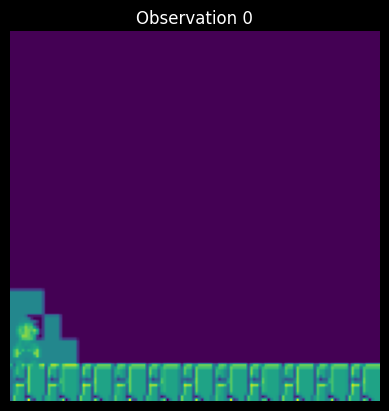

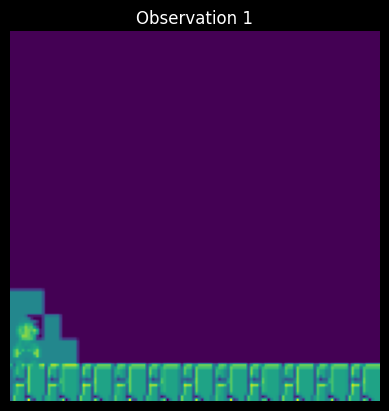

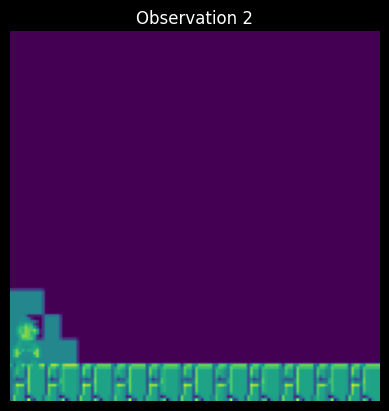

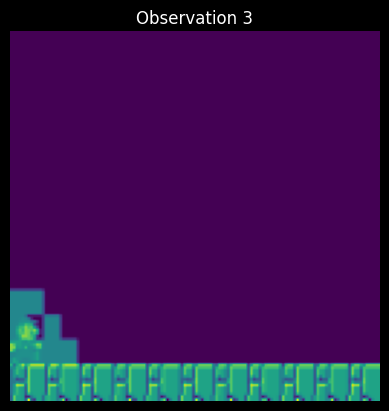

In [19]:
env = mario_utils.make_env(ENV_NAME, do_crop=True)
obs = env.reset()
obs, reward, done, info = env.step(0)
mario_utils.show_obs(obs)

In [20]:
# Hiperparámetros de entrenamiento del agente Custom DQN
TOTAL_STEPS = 10_000_000
EPISODES = 15_000

STEPS = 500
STEPS_BEFORE_TRAINING = 20_000


EPSILON_INI = 1
EPSILON_MIN = 0.05
EPSILON_DECAY = 0.99998599985
EPSILON_TIME = 1_000_000

EPISODE_BLOCK = 100

BATCH_SIZE = 64
BUFFER_SIZE = 15_000

GAMMA = 0.99
LEARNING_RATE = 1e-4

In [21]:
from custom_dqn_agent import CustomDQNAgent
from dqn_multimodel_model import DQN_Multimodel_Model

MODEL_NAME = "CUSTOM_DQN_" + ENV_NAME + "_" + str(EPISODES)

# crop the screen
env = mario_utils.make_env(ENV_NAME, do_crop=True)

# Cada vez que hacemos un experimento reseteamos la semilla para tener reproducibilidad
env.seed(42)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

modelo_a = DQN_Multimodel_Model(
    env.observation_space.shape, env.action_space.n, pos_dim=1, time_dim=1
).to(DEVICE)

modelo_b = DQN_Multimodel_Model(
    env.observation_space.shape, env.action_space.n, pos_dim=1, time_dim=1
).to(DEVICE)


agent = CustomDQNAgent(
    env,
    modelo_a,
    modelo_b,
    process_state,
    BUFFER_SIZE,
    BATCH_SIZE,
    LEARNING_RATE,
    GAMMA,
    epsilon_i=EPSILON_INI,
    epsilon_f=EPSILON_MIN,
    epsilon_anneal_time=EPSILON_TIME,
    epsilon_decay=EPSILON_DECAY,
    episode_block=EPISODE_BLOCK,
    steps_before_training=STEPS_BEFORE_TRAINING,
)

# Para entrenar el agente descomentar la siguiente línea (y comentar las siguientes)
# agent.train(EPISODES, STEPS, TOTAL_STEPS, writer_name=MODEL_NAME)

# Modelo preentrenado
modelo_a.load('./show_cases/models/CustomDQN.pt')
modelo_b.load('./show_cases/models/CustomDQN.pt')

In [22]:
#initial environment
env = mario_utils.make_env(ENV_NAME, do_crop=True)
wrapped_env = mario_utils.wrap_env(env)
agent.record_test_episode(wrapped_env)

In [24]:
# Debido a que los logs son muy pesados, se adjunta una imagenes en /assets/logs con el resultado de la ejecución.
# Si se desea ver los logs, puden ser descargados en: https://drive.google.com/drive/folders/1ILCAR9Z3_K4Vn7-gyTeJBVghd6Ay6jlZ?usp=sharing y descomprimidos en la raiz de este proyecto.
tensorboard --logdir=runs

# Comparaciones, Resultados, Comentarios...

Este proyecto implementó tres técnicas de aprendizaje por refuerzo profundo para entrenar a un agente a jugar Super Mario Bros, obteniendo resultados claros y mejoras sucesivas con cada implementación.

El algoritmo inicial DQN permitió al agente aprender a navegar por el juego, aunque a veces tenía dificultades con las decisiones a largo plazo. Era evidente que el agente podía aprender de las recompensas y evitar los enemigos, pero no siempre lograba entender la estructura del juego, lo que resultaba en decisiones subóptimas.

La implementación del DDQN mejoró significativamente el rendimiento. La inclusión de la red objetivo redujo la sobreestimación de los valores de Q, y se observó que el agente adoptaba políticas de aprendizaje más estables y optimizadas. Sin embargo, todavía había margen para mejorar, especialmente en términos de gestión del tiempo en el juego.

La variante personalizada de DQN resultó ser la más efectiva. El recorte de la observación permitió al agente enfocarse en las regiones más relevantes del entorno, lo que eliminó gran cantidad de ruido y de información innecesaria. La Prioritized Experience Replay permitió un aprendizaje más efectivo a partir de experiencias críticas. La adición de entradas escalares a la red convolucional proporcionó un contexto más rico para las decisiones del agente. Todo esto condujo a un comportamiento de juego notablemente mejor, con un rendimiento más consistente y estratégico.

El análisis final mostró claramente la eficacia de las mejoras implementadas, con la variante personalizada de DQN superando a las otras implementaciones. Sin embargo, es importante notar que incluso el mejor rendimiento del agente todavía puede estar lejos de un jugador humano experto. Este trabajo ha demostrado el potencial de DRL para juegos como Super Mario Bros, pero también ha subrayado la necesidad de más investigación y desarrollo en esta área para alcanzar el nivel de competencia humana.

A lo largo de este proyecto, me encontré incentivado a adentrarme más profundamente en la investigación de las técnicas de aprendizaje por refuerzo. La experiencia directa con DQN y DDQN, y el análisis cuidadoso de sus limitaciones, condujeron a la exploración de estrategias más avanzadas y personalizadas para mejorar la efectividad del agente. Esta búsqueda condujo a la creación del DQN personalizado, donde se incluyeron elementos adicionales de observación y se implementó la Prioritized Experience Replay.

Este proceso de investigación y desarrollo personalizado fue en sí mismo un aprendizaje invaluable. Permitió un entendimiento más profundo de los retos y posibilidades inherentes a la aplicación de DRL en videojuegos, y puso de relieve la importancia de la experimentación y personalización en la mejora del rendimiento del agente.

En definitiva, el desarrollo del DQN personalizado fue un viaje de descubrimiento motivado por la curiosidad y el deseo de mejorar. Este proceso reafirmó la importancia de la investigación constante y la innovación en el campo del aprendizaje por refuerzo profundo, y fortaleció mi compromiso con la exploración y mejora continua en futuros proyectos.

Además de los logros documentados en este trabajo, se realizaron numerosas experimentaciones adicionales que no se reflejan directamente en el proyecto final. Entre ellas se incluyen ajustes como aumentar la cantidad de movimientos posibles para todas las implementaciones y modificar la función de recompensa para que el agente se concentre también en acumular puntos en el juego, no solo en avanzar hacia la derecha.

Estos experimentos, junto con muchos otros, fueron un ejercicio de paciencia y dedicación, dado que cada cambio requería entre 10 a 15 horas de tiempo de entrenamiento para evaluar sus efectos. Esta experiencia subrayó la importancia de implementar métodos para monitorizar el progreso de manera más eficaz. Por ejemplo, establecer registros cada hora para evaluar si los cambios que se están implementando tienen sentido o están produciendo los resultados esperados.

Aprendí la importancia de la persistencia y la adaptabilidad en la experimentación científica y cómo la observación cuidadosa puede conducir a mejoras significativas. Esta experiencia me ha dejado con valiosas lecciones para futuras investigaciones y la confianza para seguir explorando y probando nuevas ideas en el campo del aprendizaje por refuerzo profundo.

![](./assets/images/d15ul9wlg69thijvq4ny.png)